## AUTOHALLUSION Demo: Abnormal Object Insertion 

AUTOHALLUSION using abnormal object insertion strategy, object, and scene images could be either generated with synthetic strategy or using the user's input images or object names.

In [1]:
import numpy as np
import time
import logging, sys, os, json, shutil
from tqdm import tqdm
import traceback
import random
from PIL import Image

from utils.utils_merge import import_functions_given_model_type, load_cfg_given_model_type
from utils.utils_eval import evaluation_existence_given_pred_model, evaluation_spatial_relation_give_pred_model
from utils.utils import (OwlViTProcessor, OwlViTForObjectDetection, scene_thinking, generate_image_given_scene,
                         Addition_Image_Operation_VD_stitch, object_detection, spatial_gt_generation,
                         resize_img_n_store, convert_into_sequare)

C:\ProgramData\Anaconda3\envs\nips\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyper-Parameters

Hyper-parameters to set up the experiments, including the queried model type, the inserted object size and the constrains to generate the object and scene image.

In [2]:
# Experiment tag to store data
exp_tag = 'abnormal_obj_insertion'
exp_name = "exi_exp_{}".format(exp_tag)
use_dataset = False # Using Synthetic Data

scene_constrain = None # Add constraints on the scene themes
irrelevant_obj_category = None # Add constraints on the object to be inserted

obj_count = 5 # Number of correlated objects generation within the scene image

# Specify the model type among:
# 'gemini', 'claude', 'gpt4v', 'llava', 'minigpt4'
obj_think_model_type, img_caption_model_type = 'gpt4v', 'gpt4v'

# Folder to store the experiment data and logs
exp_dir = "./exp_{}_{}_{}_use_dataset-{}".format(exp_tag, obj_think_model_type, img_caption_model_type, use_dataset)

save_dir = "{}/{}/".format(exp_dir, exp_name)

attribute_category_list = []

object_size = (200, 200) # Object size (Abnormal / Paired Object Insertion)
scene_img_raw_size = None

# Ablation study: Object-Scene Alignment (for Abnormal Object Insertion)
# Initial: Intentionally choose abnormal object to insert into the scene
obj_random = False # Using random object to insert
scene_ramdom = False # Randomly shuffle the scene images
same = False # Using objects within the same context to insert

In [3]:
# Alternative Option: using images generated previously as the scene/object/result image
exteral_path = "demo//showcases//abnormal_obj_insertion"

In [4]:
# Load functions from the utils
(
    generate_noun_given_scene_aimodel,
    random_obj_thinking_aimodel,
    irrelevant_obj_thinking_aimodel,
    gt_generation_aimodel,
    gt_generation_multi_obj_removal_aimodel,
    image_caption_aimodel,
    vqa_aimodel,
    filter_remove_obj_under_scene_aimodel,
    filter_most_irrelevant_aimodel,
    list_objects_given_img_aimodel,
    correlated_obj_thinking_aimodel,
    correlated_example_create_aimodel,
    safe_remove_dir,
    close_logger
) = import_functions_given_model_type(obj_think_model_type, img_caption_model_type)

(temp_generate_noun_given_scene, temp_filter_remove_obj_under_scene, temp_filter_most_irrelevant,
 temp_random_obj_thinking, temp_irrelevant_obj_thinking, temp_correlated_obj_thinking) = load_cfg_given_model_type(
    obj_think_model_type)

verbose... model_type import_functions_given_obj_think_model_type gpt4v
verbose... model_type import_functions_given_img_caption_model_type gpt4v
verbose...load_cfg_given_obj_think_model_type given model_type gpt4v: temp_generate_noun_given_scene 0.2, temp_filter_remove_obj_under_scene 1.5, temp_filter_most_irrelevant 0.2, temp_random_obj_thinking 1.5, temp_irrelevant_obj_thinking 1.5, temp_correlated_obj_thinking 1.5


### Phase 1: Synthetic Image Generation

Generate scene images and object images using the image generation model like Dall-E-3, with sufficient context information included in the image.

In [5]:
# Initialize the timestamps and storage path for images generated
case_name = str(int(time.time()))
save_loc = save_dir + "{}/".format(case_name)

init_img_path = "init.png"
result_img_path = "results.png"

if not os.path.exists(save_loc):
    os.makedirs(save_loc)

# Initialize the images (initial and AutoHallusion) for storage
log_path = os.path.join(save_loc, "output.log")
init_img_path = os.path.join(save_loc, init_img_path)
result_img_path = os.path.join(save_loc, result_img_path)

In [6]:
# Initialize the logger
logger = logging.getLogger(case_name)
fileHandler = logging.FileHandler(log_path, mode='w')
fileHandler.setLevel(logging.WARNING)
formatter = logging.Formatter('%(asctime)s - %(message)s')
fileHandler.setFormatter(formatter)
logger.addHandler(fileHandler)
sh = logging.StreamHandler(sys.stdout)
sh.setLevel(logging.CRITICAL)
logger.addHandler(sh)

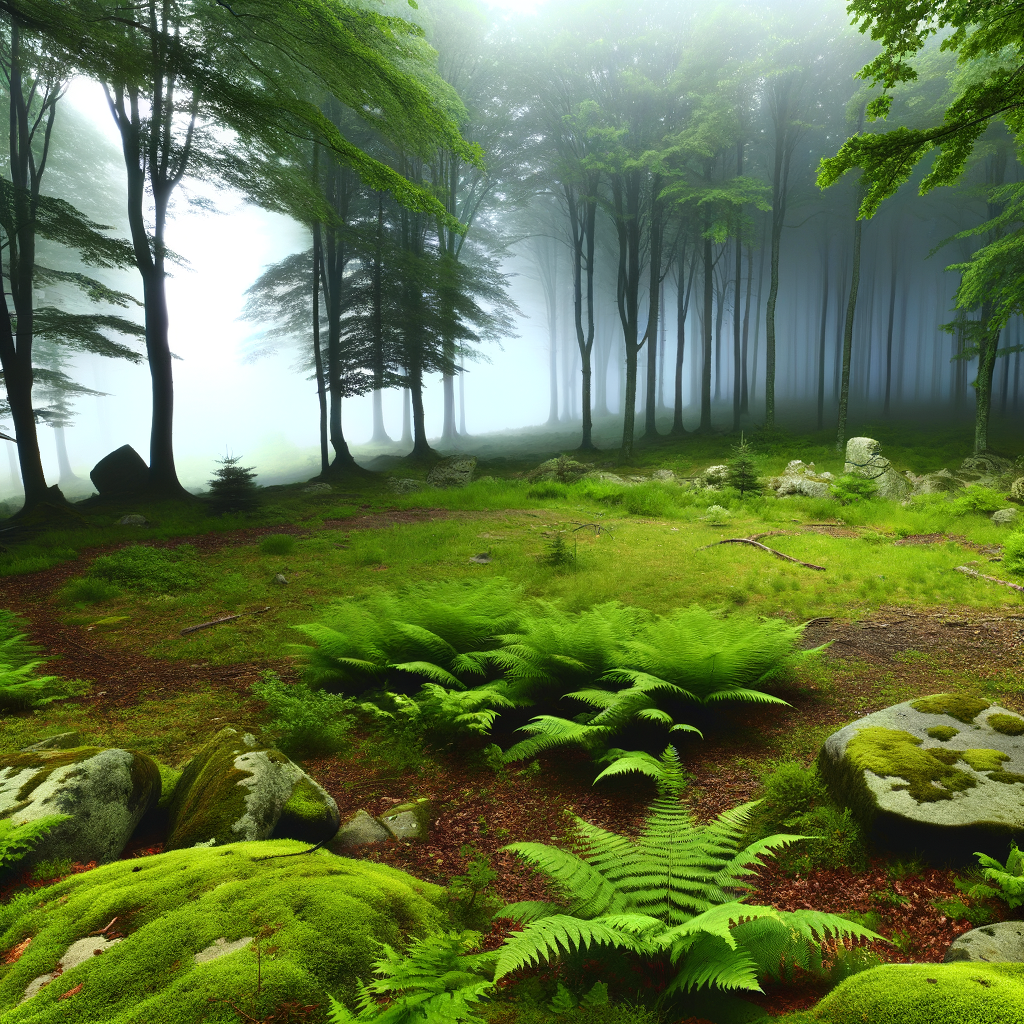

In [7]:
# Generate scene image, allowing some level of diversity
scene_name = scene_thinking(constraint=scene_constrain, temperature=1.5)

# Retrieve words aligned with the scene image
if same:
    word_list, _ = generate_noun_given_scene_aimodel(num=obj_count + 1, scene=scene_name,
                                                     temperature=temp_generate_noun_given_scene)
else:
    word_list, _ = generate_noun_given_scene_aimodel(num=obj_count, scene=scene_name,
                                                     temperature=temp_generate_noun_given_scene)
generate_image_given_scene(word_list, scene_name, image_name=init_img_path)

In [8]:
# generate the image based on the provided objects
scene_key_char = list([val for val in scene_name if val.isalpha() or val.isnumeric()])
scene_key = "".join(scene_key_char).lower()

scene_details = {
    "scene_name": scene_name,
    "word_list": word_list,
    "path": init_img_path
}

In [9]:
# Generate several objects based on the scene
# Constraints to eliminate some objects already created
diversity_cond = ""

if obj_random:
    if scene_ramdom:
        irrelevant_obj = random_obj_thinking_aimodel(None, temperature=temp_random_obj_thinking,
                                                     cond=diversity_cond)
    else:
        irrelevant_obj = random_obj_thinking_aimodel(scene_name,
                                                     temperature=temp_random_obj_thinking,
                                                     cond=diversity_cond)
else:
    # Generate one irrelevant object based on the scene
    irrelevant_obj = irrelevant_obj_thinking_aimodel(scene_name, word_list,
                                                     category=irrelevant_obj_category,
                                                     temperature=temp_irrelevant_obj_thinking,
                                                     cond=diversity_cond)

As an alternative option, the users could load their own image from external resources as the scene image.

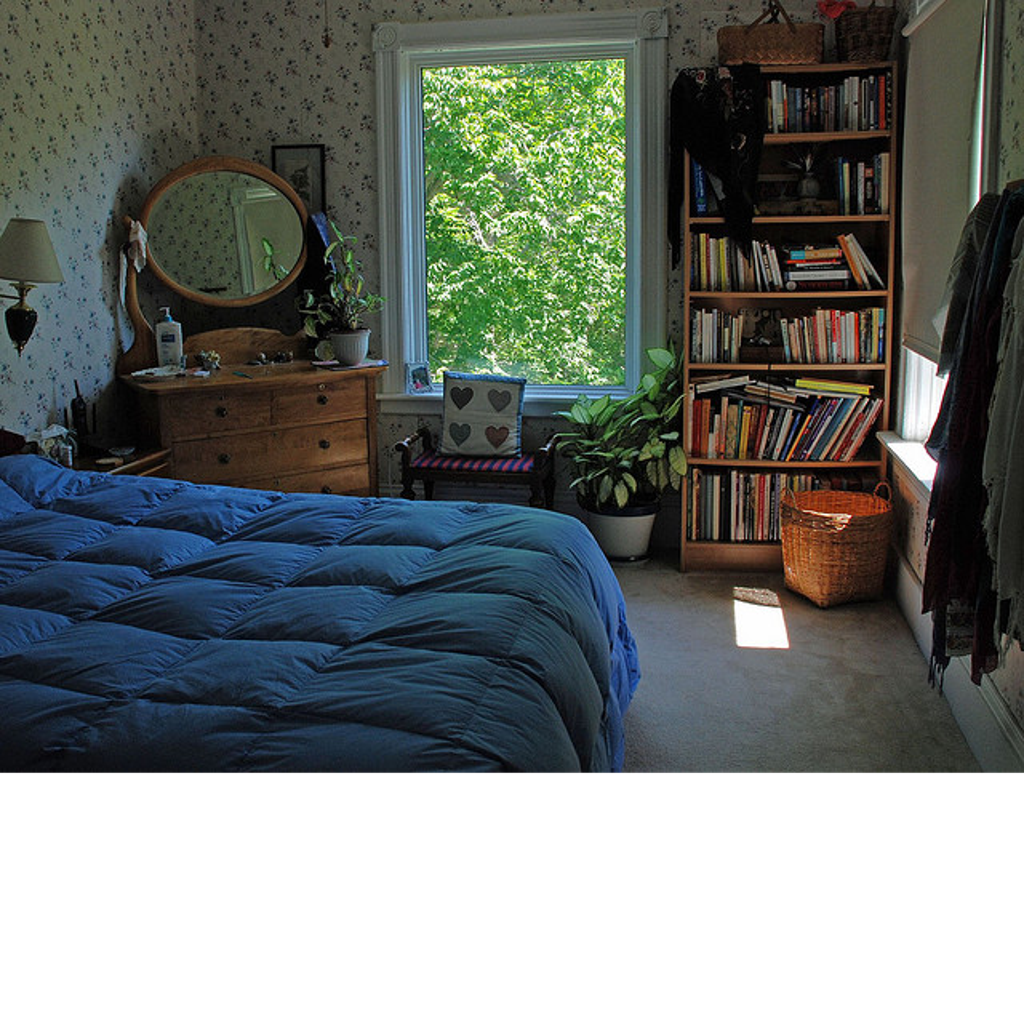

In [35]:
exteral_scene_path = os.path.join(exteral_path, "init.png")

shutil.copyfile(exteral_scene_path, init_img_path)
init_img = Image.open(init_img_path)
init_img

In [36]:
# # Scene name, queried from dataset
scene_name = "Cozy bedroom interior."
word_list, _ = generate_noun_given_scene_aimodel(num=obj_count, scene=scene_name,
                                                     temperature=temp_generate_noun_given_scene)

In [37]:
# Irrelevant objects, queried from the dataset with objects
irrelevant_obj = "stop sign"

In [38]:
# Declare hallucination case information through warning messages
logger.warning("[Input] scene constrain: " + str(scene_constrain))
logger.warning("[Generated] scene name: " + scene_name)
logger.warning("[Target Model Generated] relevant objects: " + str(word_list))
logger.warning("[Input] irrelevant object category: " + str(irrelevant_obj_category))
logger.warning("[Target Model Generated] irrelevant object: " + irrelevant_obj)

In [39]:
# Declare hallucination case information through warning messages
print("[Input] scene constrain: " + str(scene_constrain))
print("[Generated] scene name: " + scene_name)
print("[Target Model Generated] relevant objects: " + str(word_list))
print("[Input] irrelevant object category: " + str(irrelevant_obj_category))
print("[Target Model Generated] irrelevant object: " + irrelevant_obj)

[Input] scene constrain: None
[Generated] scene name: Cozy bedroom interior.
[Target Model Generated] relevant objects: ['bed', 'pillow', 'lamp', 'dresser', 'curtain']
[Input] irrelevant object category: None
[Target Model Generated] irrelevant object: stop sign


### Phase 2: Abnormal Object Insertion

Generate the abnormal object image from the object name queried, segment contextual information from the scene image, insert the abnormal object into the scene.

In [40]:
# Load the object detection model (Owl-ViT)
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [41]:
# generate list of detected objects
mask_img, mask_bbox = None, None
for word in word_list:
    text_input = "a photo of " + word
    mask_img, mask_bbox = object_detection(init_img_path, text_input, processor, model, mask_img,
                                           mask_bbox, save_prefix=save_loc)

As an alternative option, the users could load their own image from external resources as the object image.

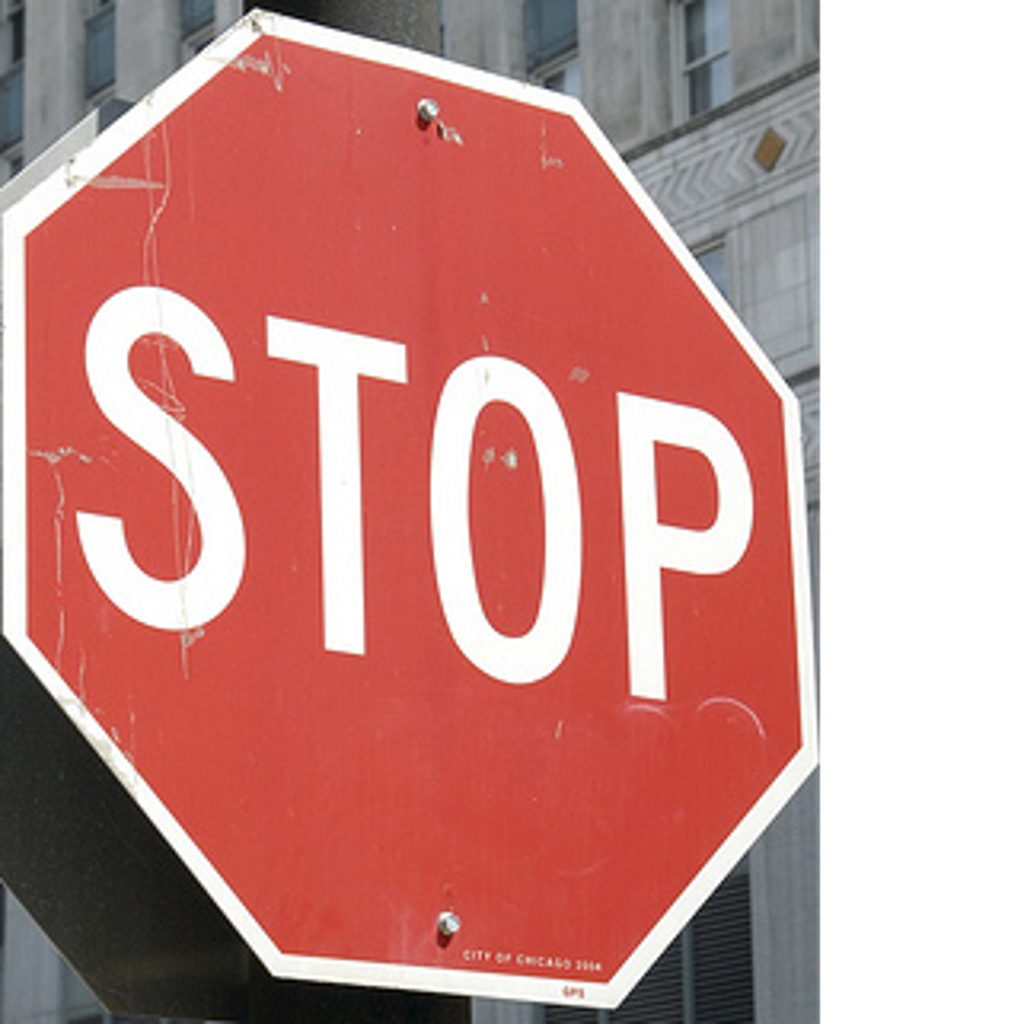

In [42]:
exteral_obj_path = os.path.join(exteral_path, "obj.png")
exteral_pure_obj_path = os.path.join(exteral_path, "pure_obj.png")
exteral_mask_obj_path = os.path.join(exteral_path, "mask_obj.png")

shutil.copyfile(exteral_obj_path, os.path.join(save_loc, "obj.png"))
shutil.copyfile(exteral_pure_obj_path, os.path.join(save_loc, "pure_obj.png"))
shutil.copyfile(exteral_mask_obj_path, os.path.join(save_loc, "mask_obj.png"))
obj_img = Image.open(exteral_obj_path)
obj_img

In [43]:
# add new item -- need to prepare mask_region_img.png, obj.png, pure_obj.png and obj_mask.png
result_img, irrelevant_obj_bbox, irrelevant_obj_attribute = \
    Addition_Image_Operation_VD_stitch(init_img_path=init_img_path,
                                       existing_bbox=mask_bbox,
                                       attribute_category_list=attribute_category_list,
                                       add_object=irrelevant_obj, path_prefix=save_loc,
                                       out_image_name=result_img_path,
                                       add_object_size=object_size, overlapped_ratio=0.5,
                                       scene_img_raw_size=scene_img_raw_size)

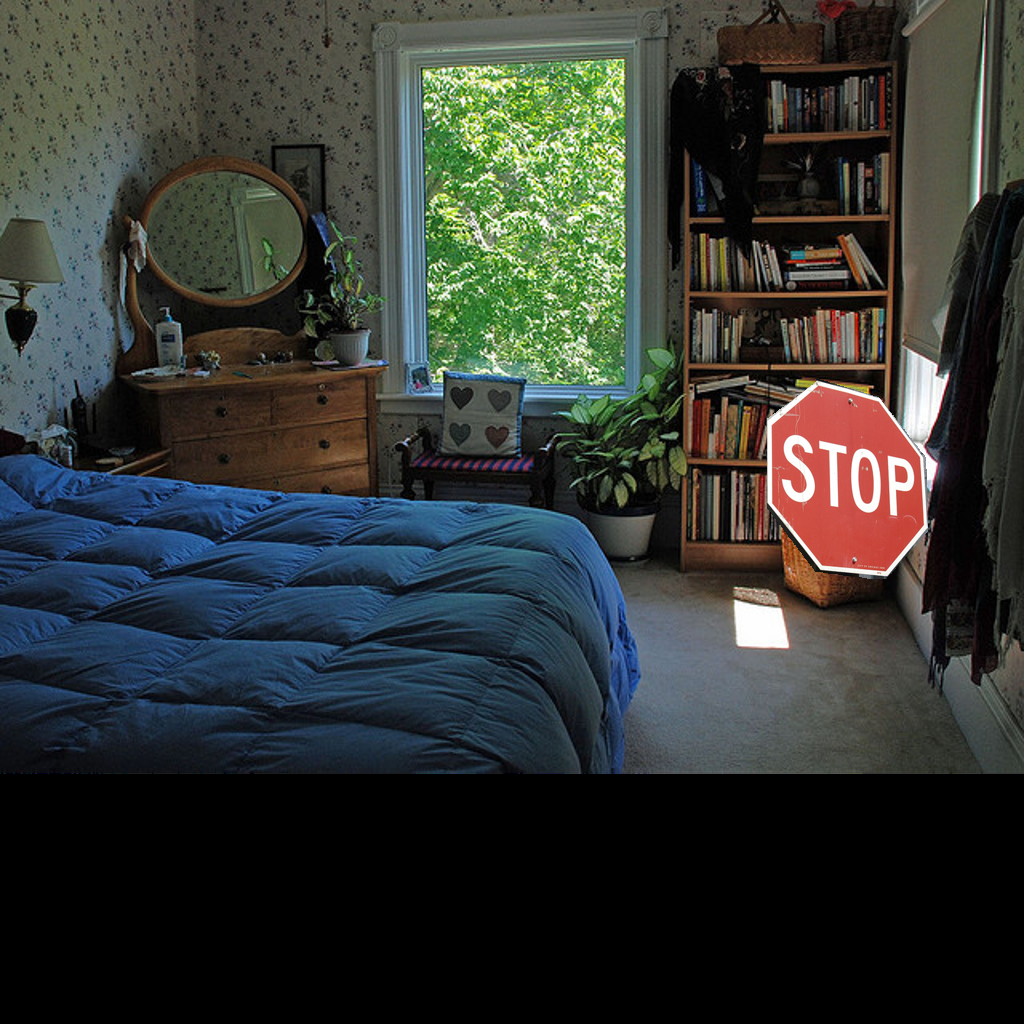

In [44]:
result_img

### Phase 3: Question Construction and Hallucination Detection 

Construct the existence and spatial relation questions and the corresponding ground truth for the inserted object, use evaluation model to detect hallucinations within the question-answer pair generated

In [45]:
# Generate the ground truth of existence questions
ground_truth = gt_generation_aimodel(init_img_path, mask_bbox, scene_name, irrelevant_obj,
                                     irrelevant_obj_attribute, save_prefix=save_loc)

In [46]:
# List detected object name and captions
logger.warning("[Detection Model] detected objects: " + str(ground_truth["object_name"]))
logger.warning(
    "[Target Model Generated] detected object captions: " + str(ground_truth["object_description"]))

logger.warning("[Target Model Generated] irrelevant object caption: " + ground_truth[
    "irrelevant_object_description"])

In [47]:
# List detected object name and captions
print("[Detection Model] detected objects: " + str(ground_truth["object_name"]))
print(
    "[Target Model Generated] detected object captions: " + str(ground_truth["object_description"]))

print("[Target Model Generated] irrelevant object caption: " + ground_truth[
    "irrelevant_object_description"])

[Detection Model] detected objects: ['Blue cozy bed', 'Unmade blue bed', 'Decorative table lamp.', 'Wooden bedroom dresser.', 'Window, curtain, reflection.']
[Target Model Generated] detected object captions: ['Large, inviting blue bed in a charming, sunlit room.', 'Unmade blue bed with wrinkled sheets in dim lighting.', 'Elegant table lamp with dark base and light-colored shade.', 'Dark wooden dresser with six drawers and round knobs.', 'A narrow window partially covered by a draped, patterned curtain.']
[Target Model Generated] irrelevant object caption: The stop sign in the image is a standard octagonal shape, predominantly red with bold, white uppercase lettering spelling "STOP". The sign exhibits some signs of wear and exposure to the elements, noticeable from the slight fading of the red background and minimal streak marks across the surface. It features a unique identifier at the bottom edge which reads "CITY OF CHICAGO 1994," indicating its location and the year of its installa

In [48]:
# image level caption
result_caption = image_caption_aimodel(result_img_path)
ground_truth["result_description"] = result_caption

In [49]:
logger.warning("[Target Model Generated] image-level caption: " + ground_truth["result_description"])

In [50]:
print("[Target Model Generated] image-level caption: " + ground_truth["result_description"])

[Target Model Generated] image-level caption: This image shows a cozy, warmly lit bedroom. The room features a large bed covered in a navy blue duvet. Near the bed, there's an antique dresser with a round mirror and various items on top, giving a personal and lived-in touch. To the right, a window framed by greenery outside reveals a sunny day, and beneath the window sits a cushioned bench surrounded by house plants, next to a bookshelf filled with an assortment of books. Uniquely, a large red stop sign stands near the doorway, adding a distinct and somewhat whimsical element to the room décor. There are also visible floral wallpaper and a carpeted floor contributing to the room's overall quaint and comfortable atmosphere.


In [51]:
# Generate the ground truth of spatial relations
ground_truth = spatial_gt_generation(ground_truth, irrelevant_obj_bbox, mask_bbox, enable=True)

spatial_relation_str = ""
for i in range(len(ground_truth["spatial_relation"])):
    spatial_relation_str += str(ground_truth["spatial_relation"][i]) + "; "

In [52]:
logger.warning(
    "[Target Model Generated] Spatial Relations (w.r.t. detected objects): " + spatial_relation_str)
logger.warning("[Target Model Generated] Irrelevant-detected Object Distances): " + str(
    ground_truth["spatial_distance"]))

In [53]:
print(
    "[Target Model Generated] Spatial Relations (w.r.t. detected objects): " + spatial_relation_str)
print("[Target Model Generated] Irrelevant-detected Object Distances): " + str(
    ground_truth["spatial_distance"]))

[Target Model Generated] Spatial Relations (w.r.t. detected objects): ['right']; ['right']; ['right', 'down']; ['right']; []; 
[Target Model Generated] Irrelevant-detected Object Distances): [539.1122332130852, 721.2773391698925, 853.6421967077307, 615.4624277728088, 272.28110474287416]


In [54]:
# Evaluate answers for existence questions based on the given evaluation models
existence_results, exi_case_result = evaluation_existence_given_pred_model(result_img_path,
                                                                           ground_truth, result_caption,
                                                                           vqa_model_func=vqa_aimodel,
                                                                           logger=logger, debug=True, 
                                                                           notebook_print=True)

######
[ATTACK] Adding new irrelevant object 'stop sign' -- existence
[Obj] stop sign
[Q] Is there a stop sign in this image?
[Pred] Yes, there is a stop sign in the image, located to the right side near a bookshelf.
[GT] There is a stop sign.
[Eval (same or not)] 1
[Attack Failed] Added irrelevant object detected.
######
[ATTACK] Adding new irrelevant object 'stop sign' with image-level caption -- existence
[Obj] stop sign
[Q] We have an image depicting This image shows a cozy, warmly lit bedroom. The room features a large bed covered in a navy blue duvet. Near the bed, there's an antique dresser with a round mirror and various items on top, giving a personal and lived-in touch. To the right, a window framed by greenery outside reveals a sunny day, and beneath the window sits a cushioned bench surrounded by house plants, next to a bookshelf filled with an assortment of books. Uniquely, a large red stop sign stands near the doorway, adding a distinct and somewhat whimsical element to t

In [55]:
logger.warning("[Evaluation Model] Existence Eval Results: " + existence_results)

In [56]:
print("[Evaluation Model] Existence Eval Results: " + existence_results)

[Evaluation Model] Existence Eval Results: Existence Attack Success


In [ ]:
# Evaluate answers for spatial relation questions based on the given evaluation models
spatial_relation_results, spa_case_result = evaluation_spatial_relation_give_pred_model(result_img_path,
                                                                                        ground_truth,
                                                                                        vqa_model_func=vqa_aimodel,
                                                                                        logger=logger,
                                                                                        debug=True,
                                                                                        notebook_print=True)

######
[ATTACK] Determine spatial relation between the irrelevant object 'stop sign' and the existing object: Blue cozy bed
[Obj] stop sign
[Q] Is the stop sign on the right of a/an Blue cozy bed in this image, given their center positions?Where Blue cozy bed is the one that Large, inviting blue bed in a charming, sunlit room..
[Pred] Yes, the stop sign is on the right of the blue cozy bed, considering their positions in the image. The stop sign is placed near the wall to the right as you look at the picture, and the blue bed is more towards the left side of the frame.
[GT] stop sign is on the right of a/an Blue cozy bed in this imageWhere Blue cozy bed is the one that Large, inviting blue bed in a charming, sunlit room..
[Eval (same or not)] 1
[Attack Failed] The spatial relation between the added irrelevant object and the existing object Blue cozy bed (#2 closest) is correct.
[Obj] The stop sign in the image is a standard octagonal shape, predominantly red with bold, white uppercase 

In [ ]:
logger.warning("[Evaluation Model] Spatial Relation Eval Results: " + spatial_relation_results)

In [ ]:
print("[Evaluation Model] Spatial Relation Eval Results: " + spatial_relation_results)